In [1]:
using DifferentialEquations, DataFrames, Plots

In [2]:
function ribofinal(dydt, init, (rates, parameters), t)
    dm, kb, ku, rho = rates 
    Kp, thetar, kq, thetax, wr0, wq0, we0, gmax, aatot, vt, Kt, s0, vm, Km, ns, nq, nr, nx = parameters
    a, em, et, mm, mq, mr, mt, eq, er, rm1m, rm1q, rm1r, rm1t, rm2m, rm2q, rm2r, rm2t, si, zmm, zmq, zmr, zmt = init
    
    #define change arrays
    da, dem, det, dmm, dmq, dmr, dmt, deq, der, drm1m, drm1q, drm1r, drm1t, drm2m, drm2q, drm2r, drm2t, dsi, dzmm, dzmq, dzmr, dzmt = zeros(length(dydt))
    
    
    # import
    # s0 -> si; following a Michaelis-Menten dynamic: et*vt*s0/(Kt+s0)
    imp = (et*vt*s0/(Kt + s0))
    
    dsi = dsi + imp
    
    # metabolism
    # si -> a; following a Michaelis-Menten dynamic: em*vm*si/(Km + si)
    nucat= em*vm*si/(Km + si)
    
    da = da +nucat * ns
    dsi = dsi -nucat
        
    # transcription 
    # 0 -> rx; following a Michaelis-Menten dynamic: x*a/(theta+a)
    function transcriptionMM(wx,theta) wx*a/(theta+a) end
    
    dmm = dmm +transcriptionMM(we0,thetax)
    dmr = dmr +transcriptionMM(wr0,thetar)
    dmt = dmt +transcriptionMM(we0,thetax)
    
    # q-compartment inhibition
    # In the case of compartment q, included autoinhibition 1+(q/kq^nq)
    qMM = 1+(eq/kq)^nq

    dmq = dmq + transcriptionMM(wq0,thetax)/qMM   
    
    # translation
    
    ## binding
    # rx + r <-> rm1x; at forward rate: kb*rx*r
    #                  at backward rate: ku*rm1x

    function bind(mx) mx*er*kb end
    function unbind(rm1x) rm1x*ku end

    dmm = dmm + unbind(rm1m) -bind(mm)
    dmq = dmq + unbind(rm1q) -bind(mq)
    dmr = dmr + unbind(rm1r) -bind(mr)
    dmt = dmt + unbind(rm1t) -bind(mt)
    der = der + unbind(rm1r+rm1t+rm1m+rm1q) -bind(mr+mt+mm+mq)
    drm1m = drm1m -unbind(rm1m) +bind(mm)
    drm1q = drm1q -unbind(rm1q) +bind(mq)
    drm1r = drm1r -unbind(rm1r) +bind(mr)
    drm1t = drm1t -unbind(rm1t) +bind(mt)
    
    ## translation initiation
    # rm1x -> rm2x + mx; at forward rate: rho*rm1x
    function transInit(riborna) rho*riborna end

    dmm = dmm +transInit(rm1m)
    dmq = dmq +transInit(rm1q)
    dmr = dmr +transInit(rm1r)
    dmt = dmt +transInit(rm1t)
    drm1m = drm1m -transInit(rm1m)
    drm1q = drm1q -transInit(rm1q)
    drm1r = drm1r -transInit(rm1r)
    drm1t = drm1t -transInit(rm1t)
    drm2m = drm2m +transInit(rm1m)
    drm2q = drm2q +transInit(rm1q)
    drm2r = drm2r +transInit(rm1r)
    drm2t = drm2t +transInit(rm1t)
    
    ## main part and release
    # rm2x + nx * a ->  x + r; at forward rate: gmax*a/(Kg + a)
    
    Kg= gmax/Kp
    gamma= gmax*a/(Kg + a)

    function transRate(transRibo,protLen) transRibo*gamma/protLen end
    
    da = da -gamma*(rm2q + rm2r + rm2t + rm2m)
    dem = dem +  transRate(rm2m,nx)
    deq = deq +  transRate(rm2q,nx)
    der = der +2*transRate(rm2r,nr) +transRate(rm2t+rm2m+rm2q,nx)
    det = det +  transRate(rm2t,nx)
    drm2m = drm2m -transRate(rm2m,nx)
    drm2q = drm2q -transRate(rm2q,nx)
    drm2r = drm2r -transRate(rm2r,nr)
    drm2t = drm2t -transRate(rm2t,nx)

    # chloramphenicol
    # rmx <-> zmx ; at a forward rate cl*k_cm and backward b=0
    f = cl*k_cm
    
    function inhibit(rmx) f*rmx end
    function uninhibit(zmx) b*zmx end
    
    drm2m = drm2m -inhibit(rm2m) +uninhibit(zmm)
    drm2q = drm2q -inhibit(rm2q) +uninhibit(zmq)
    drm2r = drm2r -inhibit(rm2r) +uninhibit(zmr)
    drm2t = drm2t -inhibit(rm2t) +uninhibit(zmt)
    dzmm = dzmm +inhibit(rm2m) -uninhibit(zmm)
    dzmq = dzmq +inhibit(rm2q) -uninhibit(zmq)
    dzmr = dzmr +inhibit(rm2r) -uninhibit(zmr)
    dzmt = dzmt +inhibit(rm2t) -uninhibit(zmt)
    
    # degradation
    # mx -> 0; at a rate dm*mx
    function degrade(mx) dm*mx end
    dmm = dmm -degrade(mm)
    dmq = dmq -degrade(mq)
    dmr = dmr -degrade(mr)
    dmt = dmt -degrade(mt)
    
    # growth rate
    ttrate= (rm2q + rm2r + rm2t + rm2m)*gamma
    lam= ttrate/aatot

    #dilution
    # x -> 0; at a rate lam*x
    function dilute(x) lam*x end

    da = da -dilute(a)
    dem = dem -dilute(em)
    det = det -dilute(et)
    dmm = dmm -dilute(mm)
    dmq = dmq -dilute(mq)
    dmr = dmr -dilute(mr)
    dmt = dmt -dilute(mt)
    deq = deq -dilute(eq)
    der = der -dilute(er)
    drm1m = drm1m -dilute(rm1m)
    drm1q = drm1q -dilute(rm1q)
    drm1r = drm1r -dilute(rm1r)
    drm1t = drm1t -dilute(rm1t)
    drm2m = drm2m -dilute(rm2m)
    drm2q = drm2q -dilute(rm2q)
    drm2r = drm2r -dilute(rm2r)
    drm2t = drm2t -dilute(rm2t)
    dsi = dsi -dilute(si)
    dzmm = dzmm - dilute(dzmm)
    dzmq = dzmq - dilute(dzmq)
    dzmr = dzmr - dilute(dzmr)
    dzmt = dzmt - dilute(dzmt)
    
    dydt[1] = da
    dydt[2] = dem
    dydt[3] = det
    dydt[4] = dmm
    dydt[5] = dmq
    dydt[6] = dmr
    dydt[7] = dmt
    dydt[8] = deq
    dydt[9] = der
    dydt[10] = drm1m
    dydt[11] = drm1q
    dydt[12] = drm1r
    dydt[13] = drm1t
    dydt[14] = drm2m
    dydt[15] = drm2q
    dydt[16] = drm2r
    dydt[17] = drm2t
    dydt[18] = dsi
    dydt[19] = zmm
    dydt[20] = zmq
    dydt[21] = zmr
    dydt[22] = zmt

end 


ribofinal (generic function with 1 method)

In [3]:
# parameters

# define rate constants
dm= 0.1
kb= 1
ku= 1.0
rho= 7.2

Kp= 7.0
thetar= 426.87
kq= 152219
thetax= 4.38
wr0= 93
wq0= 949
we0= 4.38
gmax= 1260.0
aatot= 1.0e8
vt= 726.0
Kt= 1.0e3
s0= 1.0e4
vm= 5800.0
Km= 1.0e3
ns= 0.5
nq= 4
nr= 7549.0
nx= 300.0
b = 0
cl= 0
k_cm = 0.00554752/662.435565

rates = [dm, kb, ku, rho]
parameters=  [Kp, thetar, kq, thetax, wr0, wq0, we0, gmax, aatot, vt, Kt, s0, vm, Km, ns, nq, nr, nx]

# define initial conditions
a_0= 1000.0
em_0= 10
et_0= 10
mm_0= 10
mq_0= 10
mr_0= 10
mt_0= 10
eq_0= 10
er_0= 10.0
rm1m_0= 0
rm1t_0= 0
rm1q_0= 0
rm1r_0= 0
rm2m_0= 0
rm2t_0= 0
rm2q_0= 0
rm2r_0= 0
si_0= 0
zmm_0= 0
zmq_0= 0
zmr_0= 0
zmt_0= 0

init= [a_0, em_0, et_0, mm_0, mq_0, mr_0, mt_0, eq_0, er_0, rm1m_0, rm1q_0, rm1r_0, rm1t_0, rm2m_0, rm2q_0, rm2r_0, rm2t_0, si_0, zmm_0, zmq_0, zmr_0, zmt_0]
species = [:a, :em, :et, :mm, :mq, :mr, :mt, :eq, :er, :rm1m, :rm1q, :rm1r, :rm1t, :rm2m, :rm2q, :rm2r, :rm2t, :si, :zmm, :zmq, :zmr, :zmt]

tspan = (0.,10000.)
prob = ODEProblem(ribofinal,init,tspan, (rates,parameters))

sol = solve(prob);

solDF = DataFrame([[j[i] for j in sol.u] for i=1:length(sol.u[1])], species)

345×22 DataFrame. Omitted printing of 15 columns
│ Row │ a       │ em      │ et      │ mm      │ mq      │ mr      │ mt      │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 1000.0  │ 10.0    │ 10.0    │ 10.0    │ 10.0    │ 10.0    │ 10.0    │
│ 2   │ 1000.0  │ 10.0    │ 10.0    │ 9.99996 │ 10.0004 │ 9.99998 │ 9.99996 │
│ 3   │ 1000.0  │ 10.0    │ 10.0    │ 9.99952 │ 10.0042 │ 9.99982 │ 9.99952 │
│ 4   │ 1000.0  │ 10.0    │ 10.0    │ 9.99513 │ 10.0425 │ 9.9982  │ 9.99513 │
│ 5   │ 1000.02 │ 10.0    │ 10.0    │ 9.95196 │ 10.4255 │ 9.98257 │ 9.95196 │
│ 6   │ 1000.43 │ 10.0    │ 10.0    │ 9.80261 │ 11.832  │ 9.93384 │ 9.80261 │
│ 7   │ 1002.09 │ 10.0    │ 10.0    │ 9.58282 │ 14.1955 │ 9.88116 │ 9.58282 │
│ 8   │ 1006.06 │ 10.0003 │ 10.0003 │ 9.33315 │ 17.5261 │ 9.86331 │ 9.33315 │
│ 9   │ 1013.58 │ 10.0011 │ 10.0011 │ 9.08645 │ 22.1119 │ 9.93008 │ 9.08645 │
│ 10  │ 1025.13 │ 10.0031 │ 10.0031 │ 8.89321 │ 28.1315 │ 10.1411 │ 8.89321 │
⋮
│ 335 │ 40.6562 │ 3400.94 │ 3400.94 │ 35.0065 │ 2016.08 │ 71.6    │ 35.0065 │
│ 336 │ 40.6562 │ 3404.44 │ 3404.44 │ 35.0018 │ 2015.81 │ 71.5904 │ 35.0018 │
│ 337 │ 40.6562 │ 3406.24 │ 3406.24 │ 34.9994 │ 2015.67 │ 71.5855 │ 34.9994 │
│ 338 │ 40.6562 │ 3407.03 │ 3407.03 │ 34.9984 │ 2015.61 │ 71.5833 │ 34.9984 │
│ 339 │ 40.6562 │ 3407.31 │ 3407.31 │ 34.998  │ 2015.59 │ 71.5826 │ 34.998  │
│ 340 │ 40.6562 │ 3407.38 │ 3407.38 │ 34.9979 │ 2015.58 │ 71.5824 │ 34.9979 │
│ 341 │ 40.6562 │ 3407.38 │ 3407.38 │ 34.9979 │ 2015.58 │ 71.5824 │ 34.9979 │
│ 342 │ 40.6562 │ 3407.38 │ 3407.38 │ 34.9979 │ 2015.58 │ 71.5824 │ 34.9979 │
│ 343 │ 40.6562 │ 3407.38 │ 3407.38 │ 34.9979 │ 2015.58 │ 71.5824 │ 34.9979 │
│ 344 │ 40.6562 │ 3407.38 │ 3407.38 │ 34.9979 │ 2015.58 │ 71.5824 │ 34.9979 │
│ 345 │ 40.6562 │ 3407.38 │ 3407.38 │ 34.9979 │ 2015.58 │ 71.5824 │ 34.9979 │

In [4]:
solDF[end,:a]

40.65615425604748

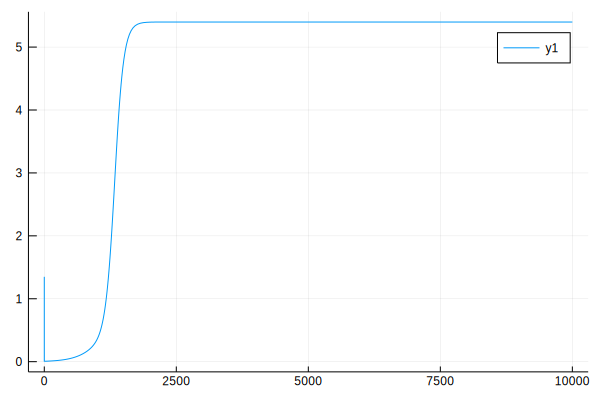

In [5]:
plot(sol.t,[i[10] for i in sol.u])

In [6]:
function calculateLambda(finalState, parameters)
    Kg= gmax/Kp
    a = finalState[:a]
    gamma= gmax*a/(Kg + a)
    ttrate= sum(finalState[[:rm2q, :rm2r, :rm2t, :rm2m]])*gamma
    
    return(ttrate/aatot)
    
end

function calculateDivRate(finalState,parameters)
    lam = calculateLambda(finalState,parameters)
    
    return(log(2)/lam)
end

function calculateTotalRNA(finalState, parameters)
    freeMRNA = sum(finalState[[:mm, :mq, :mr, :mt]])
    occupiedMRNA = sum(finalState[[:rm1m, :rm1q, :rm1r, :rm1t]])
    
    return(freeMRNA + occupiedMRNA)
end

function calculateWorkingRibosomes(finalState, parameters)
    rAtWork = sum(finalState[[:rm2q, :rm2r, :rm2t, :rm2m]])
    rNotAtWork = sum(finalState[[:er, :rm1m, :rm1q, :rm1r, :rm1t]])

    return(rAtWork /(rAtWork + rNotAtWork))
end

function testMassConservation(finalState, parameters)
    massr = sum(finalState[[:er, :rm1m, :rm1q, :rm1r, :rm1t, :rm2m, :rm2q, :rm2r, :rm2t]]) * 7549
    massx = sum(finalState[[:em, :et, :eq]]) * 300
    
    return(sum(massr) + sum(massx))
end

function calculateMFAllocation(finalState, parameters)
    em, et, eq = [solDF[end,:][CompartmentType] * nx for CompartmentType in [:em, :et, :eq]]
    er = sum(sol.u[end][9:17]) * nr
    etot = 1e8
    
    em = em/etot
    et = et/etot
    eq = eq/etot
    er = er/etot

    allocationDict = Dict()
    names =  ["Enzymatic: ","Transport: ", "Housekeeping: ", "Ribosomal: "]
    allocatedPortion = [em, et, eq, er]
    
    for (allocation, name) in zip(allocatedPortion, names)
        allocationDict[name] = allocation
    end
    
    return allocationDict
end


# Wrapper function
function obtainData(finalState, parameters)
   println("Division rate (seconds): ", calculateDivRate(finalState, parameters)) 
   println("Total RNA: ", calculateTotalRNA(finalState, parameters))
   println("Ratio of working/not working ribosomes: ", calculateWorkingRibosomes(finalState, parameters)) 
   println("Total mass (Should approximate $(aatot)): ", testMassConservation(finalState, parameters)) 
   println(calculateMFAllocation(finalState, parameters)) 

end

obtainData(solDF[end,:], parameters)

Division rate (seconds): 61.64406187742687
Total RNA: 2489.919694175568
Ratio of working/not working ribosomes: 0.9354848575350656
Total mass (Should approximate 1.0e8): 1.0000000000157651e8
Dict{Any,Any}("Housekeeping: "=>0.588709,"Enzymatic: "=>0.0102221,"Ribosomal: "=>0.390846,"Transport: "=>0.0102221)


Test nutrient efficiency effect

In [7]:
nsRange = 0.1:0.1:0.9

lamValues =[]

for nsVal in nsRange
    parameters[15] = nsVal
    prob = ODEProblem(ribofinal,init,tspan,(rates,parameters))
    sol = solve(prob)
    solDF = DataFrame([[j[i] for j in sol.u] for i=1:length(sol.u[1])], species) 
    push!(lamValues, calculateLambda(solDF[end,:], (rates,parameters)))
end


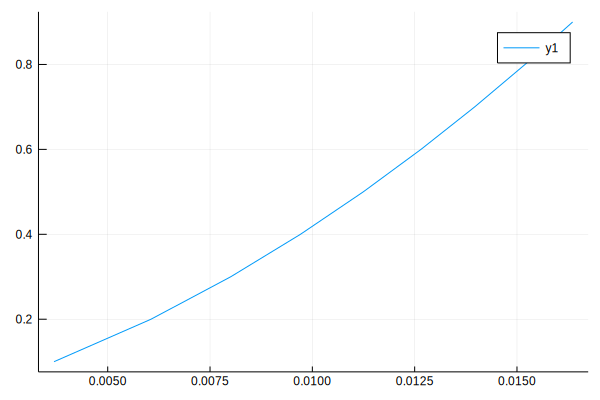

In [8]:
plot(lamValues, nsRange)